In [2]:
import cv2
import glob
import numpy as np
from scipy.ndimage import rotate

from matplotlib.pyplot import imshow
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20, 10]

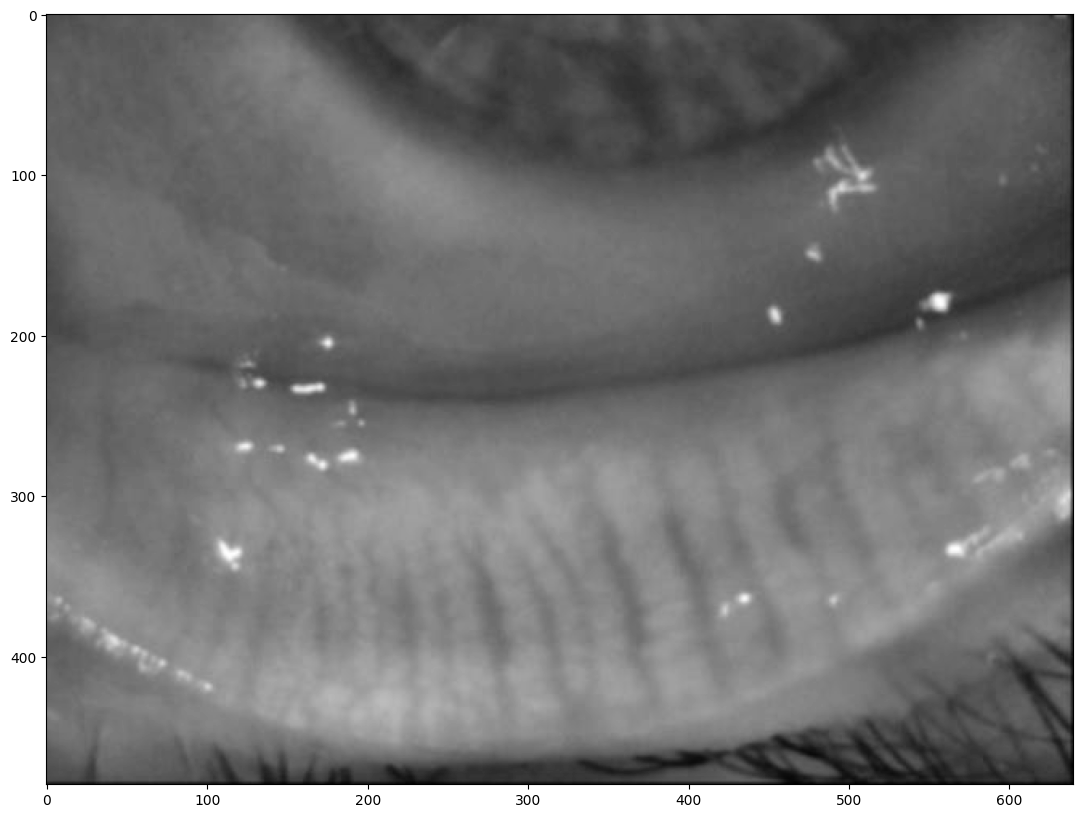

In [6]:
img_no = 94
filelist = sorted(glob.glob('../img/raw/*.jpeg'))
img_bgr = cv2.imread(filelist[img_no])
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
imshow(img, cmap='gray')

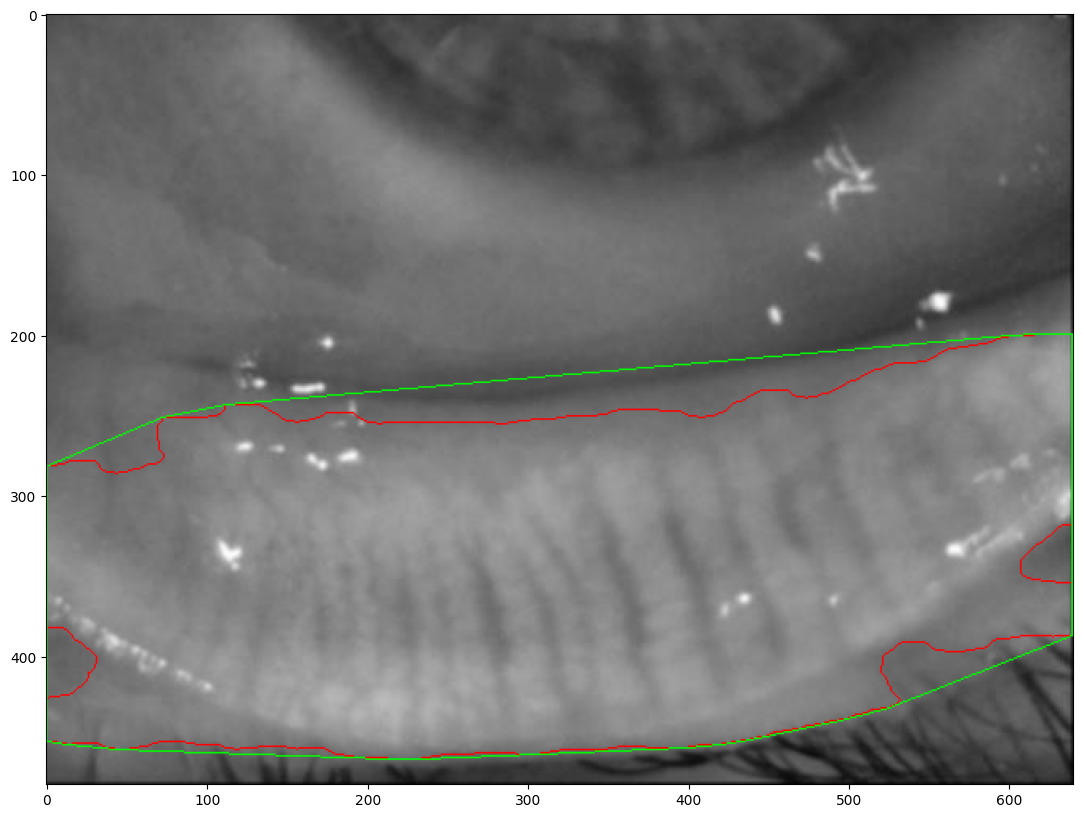

In [8]:
# Find ROI
thr, res_thr_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 10))
res_mor = cv2.morphologyEx(res_thr_img, cv2.MORPH_OPEN, kernel=kernel)
res_mor2 = cv2.morphologyEx(res_mor, cv2.MORPH_CLOSE, kernel=kernel)
cnts, _ = cv2.findContours(res_mor2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask_cnt = np.zeros(img.shape, dtype=np.uint8)
mask_hull = np.zeros(img.shape, dtype=np.uint8)
res_cnt = img_bgr.copy()
if len(cnts) != 0:
    sorted_cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt = sorted_cnts[0]
    max_hull = cv2.convexHull(max_cnt)
    cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)
    cv2.drawContours(mask_hull, [max_hull], -1, 255, thickness=cv2.FILLED)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 50))
    mask_cnt2 = cv2.morphologyEx(mask_cnt, cv2.MORPH_CLOSE, kernel=kernel, borderValue=0)
    mask_cnt3 = cv2.morphologyEx(mask_cnt, cv2.MORPH_DILATE, kernel=kernel, borderValue=0)
    cv2.drawContours(res_cnt, [max_cnt], -1, [255, 0, 0], thickness=1)
    cv2.drawContours(res_cnt, [max_hull], -1, [0, 255, 0], thickness=1)

imshow(res_cnt, cmap='gray')

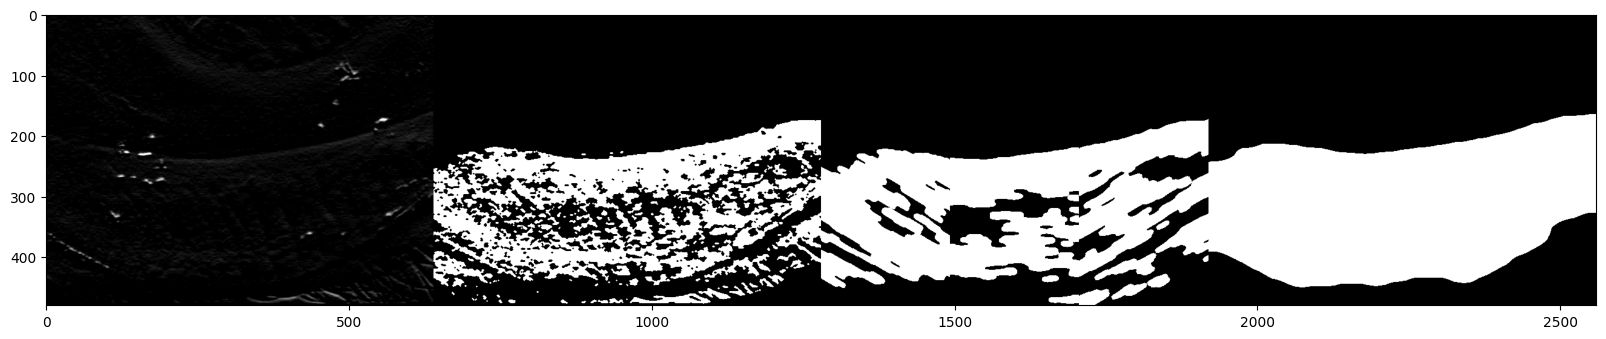

In [9]:
res_sbl = cv2.Sobel(img, dx=0, dy=1, ddepth=-1, ksize=3)
_, res_sbl2 = cv2.threshold(res_sbl*mask_cnt3, 0, 255, cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
res_sbl_mor = cv2.morphologyEx(res_sbl2, cv2.MORPH_CLOSE, kernel=kernel)
res_sbl_mor = cv2.morphologyEx(res_sbl_mor, cv2.MORPH_OPEN, kernel=kernel)

h, w = res_sbl.shape
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 5))
left = res_sbl_mor[:, 0:int(w/3)]
kernel2 = rotate(kernel, 150)
left = cv2.morphologyEx(left, cv2.MORPH_CLOSE, kernel=kernel2)
middle = res_sbl_mor[:, int(w/3):int(2*w/3)]
middle = cv2.morphologyEx(middle, cv2.MORPH_CLOSE, kernel=kernel)
right = res_sbl_mor[:, int(2*w/3):]
kernel2 = rotate(kernel, 30)
right = cv2.morphologyEx(right, cv2.MORPH_CLOSE, kernel=kernel2)
res_sbl_mor2 = cv2.hconcat([left, middle, right])

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 10))
left = res_sbl_mor2[:, 0:int(w/3)]
kernel2 = rotate(kernel, 150)
left = cv2.morphologyEx(left, cv2.MORPH_OPEN, kernel=kernel2)
middle = res_sbl_mor2[:, int(w/3):int(2*w/3)]
middle = cv2.morphologyEx(middle, cv2.MORPH_OPEN, kernel=kernel)
right = res_sbl_mor2[:, int(2*w/3):]
kernel2 = rotate(kernel, 30)
right = cv2.morphologyEx(right, cv2.MORPH_OPEN, kernel=kernel2)
res_sbl_mor3 = cv2.hconcat([left, middle, right])

cnts, _ = cv2.findContours(res_sbl_mor3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask_cnt = np.zeros(img.shape, dtype=np.uint8)
mask_hull = np.zeros(img.shape, dtype=np.uint8)
res_cnt = img_bgr.copy()
if len(cnts) != 0:
    sorted_cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt = sorted_cnts[0]
    max_hull = cv2.convexHull(max_cnt)
    cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)
    cv2.drawContours(mask_hull, [max_hull], -1, 255, thickness=cv2.FILLED)
    cv2.drawContours(res_cnt, [max_cnt], -1, [255, 0, 0], thickness=1)
    cv2.drawContours(res_cnt, [max_hull], -1, [0, 255, 0], thickness=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 50))
    mask_cnt = cv2.morphologyEx(mask_cnt, cv2.MORPH_CLOSE, kernel=kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 20))
    mask_cnt = cv2.morphologyEx(mask_cnt, cv2.MORPH_DILATE, kernel=kernel)

imshow(cv2.hconcat([res_sbl, res_sbl_mor, res_sbl_mor3, mask_cnt]), cmap='gray')

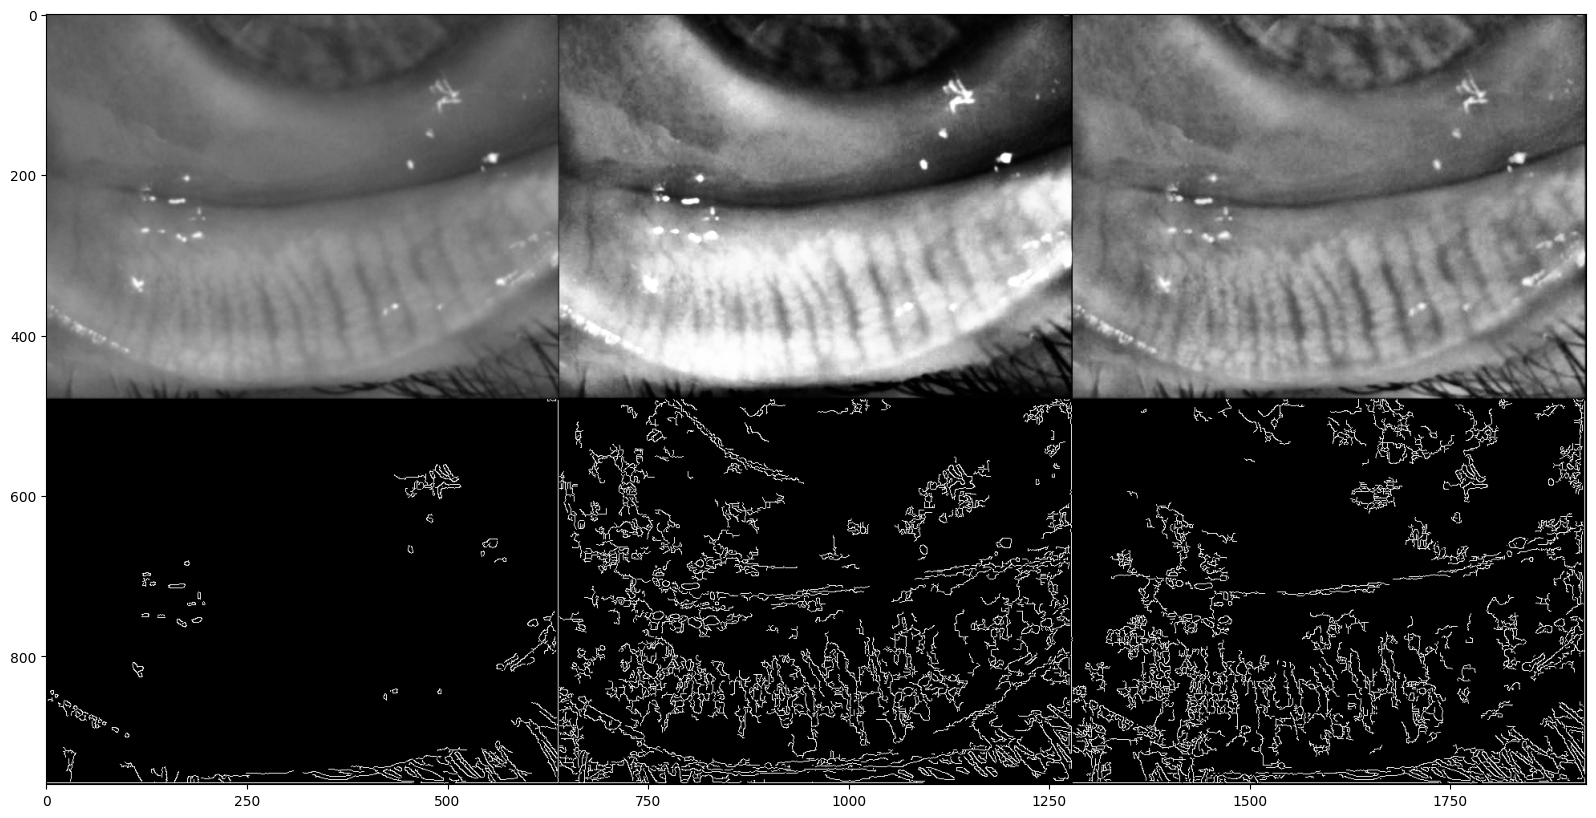

In [27]:
# Hist Eq
res_heq = cv2.equalizeHist(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
res_clahe = clahe.apply(img)
# imshow(cv2.hconcat([img, res_heq, res_clahe]), cmap='gray')
d_min = 0
d_max = 100
res_edge_img = cv2.Canny(img, d_min, d_max)
res_edge_heq = cv2.Canny(res_heq, d_min, d_max)
res_edge_clahe = cv2.Canny(res_clahe, d_min, d_max)

imshow(cv2.vconcat([cv2.hconcat([img, res_heq, res_clahe]) ,cv2.hconcat([res_edge_img, res_edge_heq, res_edge_clahe])]), cmap = 'gray')